# Estudio de lugares de observación óptima para el asteroide 99942 Apophis

<center> Agustín Vallejo Villegas </center>  
<br />
<center> Artículo #1
<center> Astrodinámica
<center> Universidad de Antioquia
<center> 2020-1




### Documentación

+ Basemap: 
    + https://matplotlib.org/basemap/index.html
    +  https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
+ Horizons Query: 
    + https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html
+ Animaciones:
    + https://colab.research.google.com/github/phoebe-project/phoebe2-docs/blob/2.1/tutorials/animations.ipynb#scrollTo=lkmX8eKePPA2
    + https://colab.research.google.com/drive/1Ofuol9wHBJKxZlDS4foZ3cm9G8fArOow#scrollTo=rd6h4K9vOtZk

### Apofis
+ 


### Librerías

In [4]:
"LIBRERÍAS BÁSICAS"
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

In [5]:
"ASTROPY"
!pip install astroquery
from astroquery.jplhorizons import Horizons

from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import astropy.units as u

In [6]:
"MAPITAS"
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip


In [7]:
"TQDM"
!pip install tqdm
from tqdm import tqdm

## Google Drive

In [8]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [9]:
!ls "/gdrive/MyDrive/Apophis/Data"

 AllRadiotelescopes.xlsx
 ephemeris.xlsx
'Radio coverage Arecibo Telescope.png'
'Radio coverage Goldstone Radio Telescope.png'
 utils.ipynb


## Efemérides

In [10]:
"UNIDAD ASTRONÓMICA"
AU = (1*u.au).to(u.m).value

"TIEMPOS"
# Se definen los tiempos desde que está a 12Rt, pasando por su máximo
# acercamiento en 6Rt y volviendo a 12Rt
t_ini = Time('2029-04-13 19:00:00',format='iso')
t_max = Time('2029-04-13 22:05:00',format='iso') #Máximo Acercamiento
# t_end = Time('2029-04-13 23:00:00',format='iso') #Final. Step de 5min
t_end = Time('2029-04-14 06:00:00',format='iso')

epochs = {'start':t_ini.value, 'stop':t_end.value, 'step':'20m'}


print("(Ignorar advertencia de ERFA si sale, es porque está muy a futuro)")

(Ignorar advertencia de ERFA si sale, es porque está muy a futuro)


/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)


In [11]:
"EFEMÉRIDES"
#Efemérides de Apofis entre los tiempos estipulados
apophis = Horizons(id='99942',epochs=epochs) 
ephemeris = apophis.ephemerides()
vectors = apophis.vectors()

#Coordenadas Ecuatoriales del Asteroide
ECUcoords = SkyCoord(ephemeris['RA'], ephemeris['DEC']
                     ,ephemeris['delta'], frame='gcrs')

Nt = np.shape(ephemeris)[0]
print(Nt)

34


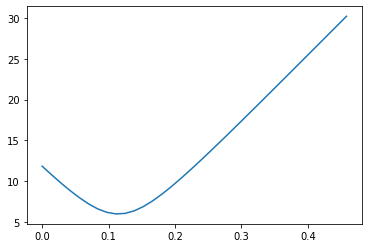

In [12]:
# ephemeris = ephemeris.to_pandas()
plt.plot(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0],ephemeris['delta']*23500)

## Plot

In [13]:
def get_lon(TIME,RA):
  """
  Saca la Longitud que estará bajo el asteroide en cada momento
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return RA - G.value

maxlons = get_lon(ephemeris['datetime_jd'],ephemeris['RA'])
maxlats = ephemeris['DEC']
deltas = ephemeris['delta']*23500

for i in range(len(maxlons)):
  if maxlons[i] < -180: maxlons[i] += 360

for i in range(1,len(maxlons)):
  if maxlons[i] > maxlons[i-1]:
    j = i-1


maxlons[j] = np.nan
maxlons = np.insert(maxlons,j,[-180])
maxlats = np.insert(maxlats,j,[maxlats[j]])
deltas = np.insert(deltas,j,[deltas[j]])

/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "utcut1" yielded 34 of "dubious year (Note 3)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 34 of "dubious year (Note 3)"
  ErfaWarning)


In [14]:
ephemeris['datetime_str'][-12] #Paso Máximo AQUI

'2029-Apr-14 02:20'

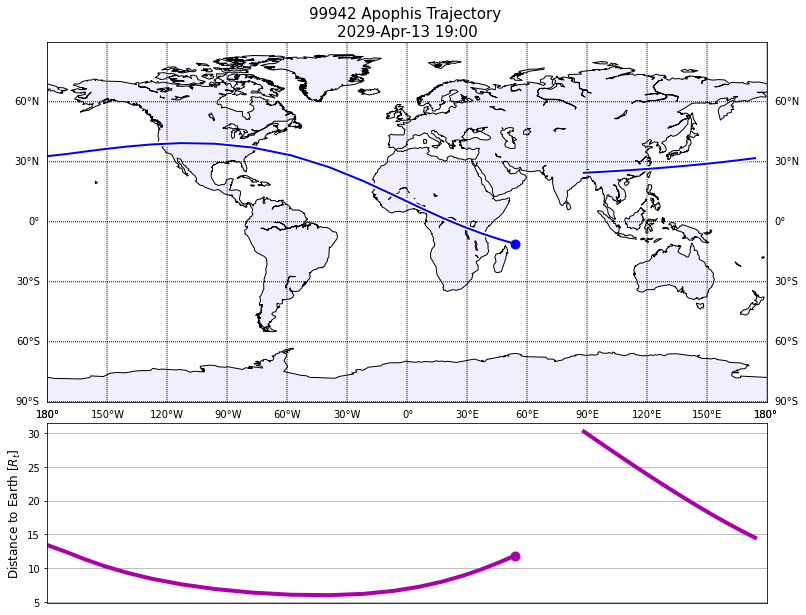

In [15]:
# definitions for the axes
left, width = 0.1, 1
bottom, height = 0.1, 0.25
spacing = 0.005

map_ax = [left, height + spacing, width, 1 - height]
deltas_ax = [left, bottom, width, height]

t = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes(map_ax)
# ax = plt.axes()
# ax.clear()
m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory \n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

ax2 = fig.add_axes(deltas_ax,sharex=ax)
# ax2.plot(maxlons,deltas,'w-',lw=5)
deltas_color = '#aa00aa'
ax2.plot(maxlons,deltas,'-',color=deltas_color,lw=4)
ax2.plot(maxlons[t],deltas[t],'o',color=deltas_color,ms=9)
ax2.set_xlim([-180,180])
ax2.set_ylabel(r"Distance to Earth $[R_t]$",size=12)
ax2.grid()


# plt.tight_layout()
plt.show()

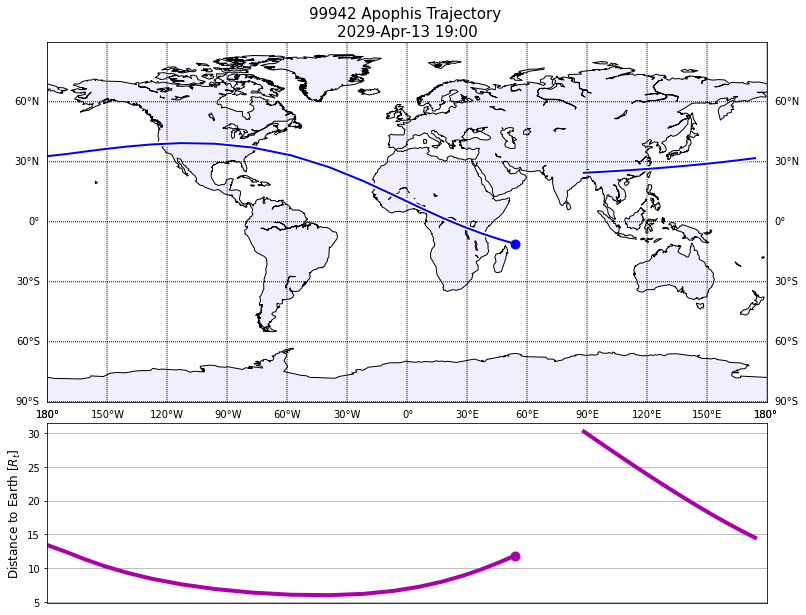

In [16]:
# definitions for the axes
left, width = 0.1, 1
bottom, height = 0.1, 0.25
spacing = 0.005

map_ax = [left, height + spacing, width, 1 - height]
deltas_ax = [left, bottom, width, height]

t = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes(map_ax)
# ax = plt.axes()
# ax.clear()
m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory \n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

ax2 = fig.add_axes(deltas_ax,sharex=ax)
# ax2.plot(maxlons,deltas,'w-',lw=5)
deltas_color = '#aa00aa'
ax2.plot(maxlons,deltas,'-',color=deltas_color,lw=4)
ax2.plot(maxlons[t],deltas[t],'o',color=deltas_color,ms=9)
ax2.set_xlim([-180,180])
ax2.set_ylabel(r"Distance to Earth $[R_t]$",size=12)
ax2.grid()


# plt.tight_layout()
plt.show()

## All Radiotelescopes

In [17]:
continents = ['Africa',	'Antarctica','Asia','Australia','Europe','North America','South America',
              'Arctic Ocean','Atlantic Ocean','Indian Ocean','Pacific Ocean']
radio = []

for continent in continents:
  try:
    cont = pd.read_excel("/gdrive/MyDrive/Apophis/Data/AllRadiotelescopes.xlsx",sheet_name=continent,index_col=0)
    radio.append(cont)
  except:
    pass

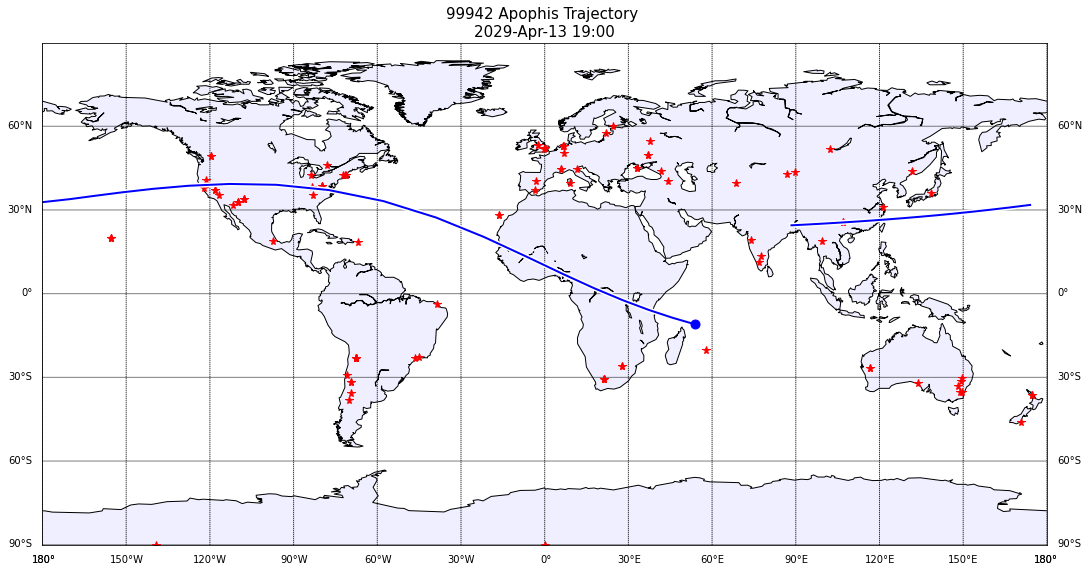

In [18]:
t = 0
fig = plt.figure(figsize=(18,15))
# ax = fig.add_axes(map_ax)
ax = plt.axes()
# ax.clear()
m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory \n"+str(ephemeris['datetime_str'][t]),size=15)

for rad in radio:
    for r,row in rad.iterrows():
        plt.plot(row.Longitude,row.Latitude,'r*',ms=8)
        # plt.annotate(str(r),(row.Longitude+5,row.Latitude),size=10)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

### USA

Text(-114.89, 35.42666667, 'Goldstone Radio Telescope')

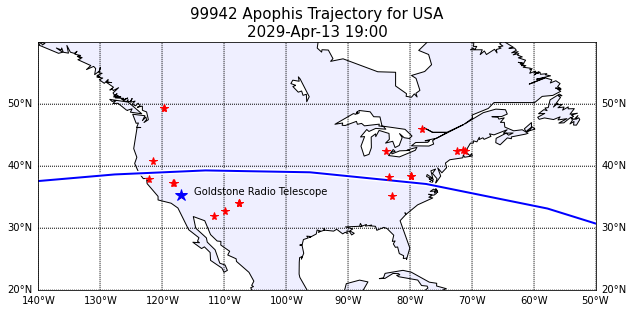

In [32]:
t = 0
fig = plt.figure(figsize=(10,10))
# ax = fig.add_axes(map_ax)
ax = plt.axes()
# ax.clear()
# m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m = Basemap(llcrnrlon=-140,llcrnrlat=20,urcrnrlon=-50,urcrnrlat=60,
            projection='cyl',lon_0=-80,lat_0=40)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(20,60,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-140,-20,10),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory for USA\n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

for r,row in radio[5].iterrows():
    ax.plot(row.Longitude,row.Latitude,'r*',ms=8)
    # ax.annotate(str(r),(row.Longitude+2,row.Latitude),size=10)

"""
n = 6  # CARMA
n = 10 # Goldstone
n = 11 # Green Bank Interferometer
n = 12 # Green Bank Telescope
n = 12 # Green Bank 140 ft
n = 18 # Leuschner Observatory
n = 20 # Morehead State University 21m
n = 22 # OVRO 40 meter Telescope
n = 28 # VLA
n = 30 # VLBA
n = 31 # PARI
"""


n = 10 # VLBA
single_one = radio[5].iloc[n]
ax.plot(single_one.Longitude,single_one.Latitude,'b*',ms=12)
ax.annotate(str(single_one.Name),(single_one.Longitude+2,single_one.Latitude),size=10)

### FAST

Text(nan, nan, 'Delingha 13.7 m')

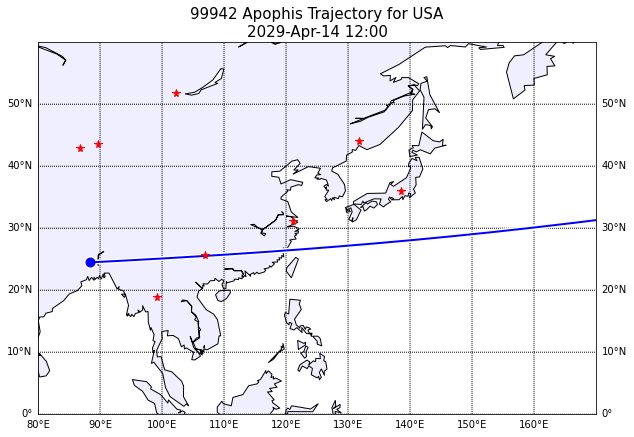

In [42]:
t = -1
fig = plt.figure(figsize=(10,10))
# ax = fig.add_axes(map_ax)
ax = plt.axes()
# ax.clear()
# m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m = Basemap(llcrnrlon=80,llcrnrlat=0,urcrnrlon=170,urcrnrlat=60,
            projection='cyl',lon_0=120,lat_0=30)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(0,60,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(80,170,10),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory for USA\n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

for r,row in radio[2].iterrows():
    ax.plot(row.Longitude,row.Latitude,'r*',ms=8)
    # ax.annotate(str(r),(row.Longitude+2,row.Latitude),size=10)

"""
n = 6  # CARMA
n = 10 # Goldstone
n = 11 # Green Bank Interferometer
n = 12 # Green Bank Telescope
n = 12 # Green Bank 140 ft
n = 18 # Leuschner Observatory
n = 20 # Morehead State University 21m
n = 22 # OVRO 40 meter Telescope
n = 28 # VLA
n = 30 # VLBA
n = 31 # PARI
"""


n = 0 # VLBA
single_one = radio[2].iloc[n]
ax.plot(single_one.Longitude,single_one.Latitude,'b*',ms=12)
ax.annotate(str(single_one.Name),(single_one.Longitude+2,single_one.Latitude),size=10)

In [20]:
"UNIDAD ASTRONÓMICA"
AU = (1*u.au).to(u.m).value

"TIEMPOS"
# Se definen los tiempos desde que está a 12Rt, pasando por su máximo
# acercamiento en 6Rt y volviendo a 12Rt
t_ini = Time('2029-04-13 19:00:00',format='iso')
t_max = Time('2029-04-13 22:05:00',format='iso') #Máximo Acercamiento
t_end = Time('2029-04-14 12:00:00',format='iso')
timesyy = {'start':t_ini.value, 'stop':t_end.value, 'step':'15m'}


print("(Ignorar advertencia de ERFA si sale, es porque está muy a futuro)")

(Ignorar advertencia de ERFA si sale, es porque está muy a futuro)


/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)


In [21]:
"EFEMÉRIDES"
#Efemérides de Apofis entre los tiempos estipulados
arecibo = { 'lon': 293.24692,
            'lat': 0.949577,
            'elevation': +0.312734}

fast   = { 'lon': 106.85667,
            'lat': 25.653055,
            'elevation': +0.312734}
apophis = Horizons(id='99942',location=fast,epochs=timesyy) 
ephemeris = apophis.ephemerides()
# apophis.vectors()

In [22]:
ephemeris.to_pandas().columns

Index(['targetname', 'datetime_str', 'datetime_jd', 'H', 'G', 'solar_presence',
       'flags', 'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate', 'DEC_rate', 'AZ',
       'EL', 'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y', 'sat_PANG',
       'siderealtime', 'airmass', 'magextinct', 'V', 'surfbright',
       'illumination', 'illum_defect', 'sat_sep', 'sat_vis', 'ang_width',
       'PDObsLon', 'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang',
       'SubSol_dist', 'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r',
       'r_rate', 'delta', 'delta_rate', 'lighttime', 'vel_sun', 'vel_obs',
       'elong', 'elongFlag', 'alpha', 'lunar_elong', 'lunar_illum',
       'sat_alpha', 'sunTargetPA', 'velocityPA', 'OrbPlaneAng',
       'constellation', 'TDB-UT', 'ObsEclLon', 'ObsEclLat', 'NPole_RA',
       'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime', 'earth_lighttime',
       'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma', 'SMIA_3sigma', 'Theta_3sigma',
       'Area_3sigma', 'RSS_3sigma', 'r_3sigma', 'r_rate_3sigm

In [23]:
ephemeris['horas'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])

In [24]:
H1 = ephemeris['horas'][np.where(ephemeris['EL'] >= 50)][0]
H2 = ephemeris['horas'][np.where(ephemeris['EL'] >= 50)][-1]
print(H1,H2)

7.749999985098839 12.49999999254942


In [25]:
ephemeris[['datetime_str','RA','DEC','EL']][np.where(ephemeris['EL'] >= 49)].to_pandas()

,datetime_str,RA,DEC,EL
0,2029-Apr-14 02:30,32.26231,28.81375,49.444581
1,2029-Apr-14 02:45,30.92751,28.40071,53.848111
2,2029-Apr-14 03:00,29.70472,28.00631,58.190385
3,2029-Apr-14 03:15,28.58125,27.62980,62.476582
4,2029-Apr-14 03:30,27.54632,27.27031,66.711211
5,2029-Apr-14 03:45,26.59070,26.92694,70.898197
6,2029-Apr-14 04:00,25.70650,26.59879,75.040955
7,2029-Apr-14 04:15,24.88687,26.28499,79.142455
8,2029-Apr-14 04:30,24.12589,25.98469,83.205280
9,2029-Apr-14 04:45,23.41839,25.69712,87.231676


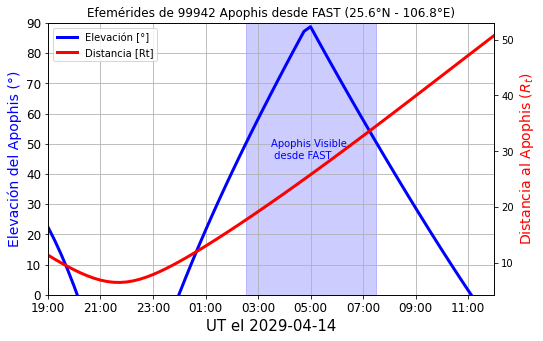

In [26]:
fig,ax = plt.subplots(figsize=(8,5))

ax.set_title("Efemérides de 99942 Apophis desde FAST (25.6°N - 106.8°E)")
ax.plot(ephemeris['horas'],ephemeris['EL'],label='Elevación [°]',lw=3,color='b')
# plt.plot(ephemeris.to_pandas()['horas'],ephemeris.to_pandas()['DEC'],label='Declinación [°]',lw=3)
# plt.plot(ephemeris.to_pandas()['horas'],ephemeris.to_pandas()['elong'],label='Elongación [°]',lw=3)

ax.fill_between([H1-0.2,H2],0,100,alpha=0.2,color='b')
ax.text(8.5,45,"Apophis Visible \n desde FAST",color='b')
# ax.hlines(50,-10,50,'b',linestyles='--')

ax.set_ylabel("Elevación del Apophis (°)",color='b',size=14)

plt.xlabel("UT el 2029-04-14",size=15)

nticks = 8
xticks = range(0,len(ephemeris),len(ephemeris)//nticks)
plt.xticks([ephemeris['horas'][i] for i in xticks],
           [ephemeris['datetime_str'][i][-5:] for i in xticks],size=12)
plt.yticks(size=12)
plt.ylim([0,90])
plt.xlim([0,ephemeris['horas'][-1]])
ax.grid()

ax2=ax.twinx()
ax2.plot(ephemeris['horas'],ephemeris['delta']*23500,label='Distancia [Rt]',lw=3,color='r')
ax.plot(ephemeris['horas'],ephemeris['delta']*0-1,label='Distancia [Rt]',lw=3,color='r')

ax2.set_ylabel("Distancia al Apophis ($R_t$)",color='r',size=14)


ax.legend(loc=2)
plt.show()

## Animación

In [27]:
def frame(t):
    ax.clear()
    ax.set_title("99942 Apophis Trajectory \n"+str(ephemeris['datetime_str'][t]),size=15)
    m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
    m.fillcontinents(color='#efefff')
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
    # Contorno blanco
    ax.plot(maxlons,maxlats,'w-',lw=5)
    ax.plot(maxlons[t],maxlats[t],'wo',ms=12)
    # Relleno azul
    ax.plot(maxlons,maxlats,'b-',lw=2)
    ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

    # AXES 2
    ax2.clear()
    deltas_color = '#aa00aa'
    ax2.plot(maxlons,deltas,'-',color=deltas_color,lw=4)
    ax2.plot(maxlons[t],deltas[t],'o',color=deltas_color,ms=9)
    ax2.set_xlim([-180,180])
    ax2.set_ylabel(r"Distance to Earth $[R_t]$",size=12)
    ax2.grid()

    plt.close()
    return fig

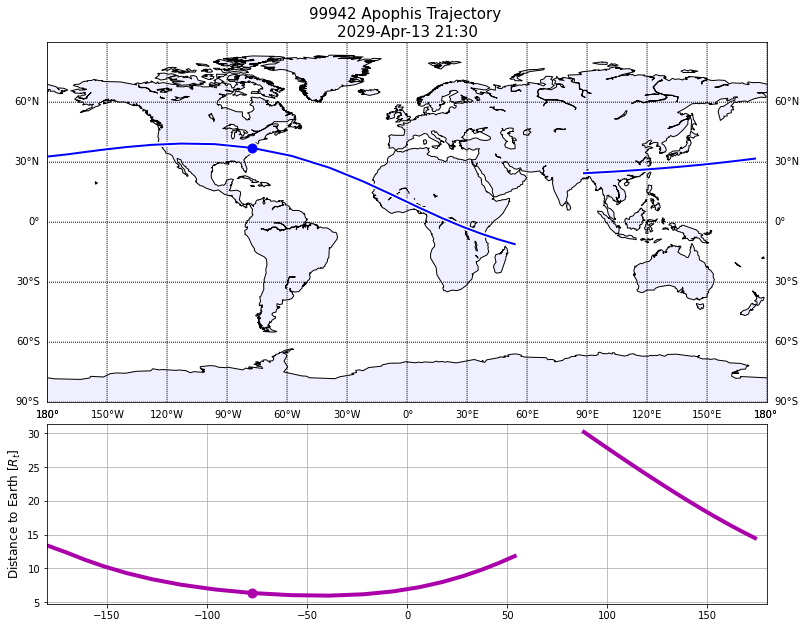

In [28]:
# definitions for the axes
left, width = 0.1, 1
bottom, height = 0.1, 0.25
spacing = 0.005

map_ax = [left, height + spacing, width, 1 - height]
deltas_ax = [left, bottom, width, height]


fig = plt.figure(figsize=(10,10))
ax = fig.add_axes(map_ax)
ax2 = fig.add_axes(deltas_ax)
frame(10)

In [29]:
# definitions for the axes
spacing = 0.005
left, width = 0.1, 0.9 - spacing
bottom, height = 0.1, 0.25

map_ax = [left, height + spacing, width, 1 - height]
deltas_ax = [left, bottom, width, height]

size = 8
fig = plt.figure(figsize=(size,size))
ax = fig.add_axes(map_ax)
ax2 = fig.add_axes(deltas_ax)
Nt = len(ephemeris)
anim = animation.FuncAnimation(fig, frame, frames=Nt, blit=False, repeat=True)

anim

IndexError: ignored

In [30]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Agustín-Vallejo'), bitrate=1800)
anim.save("Apophis.mp4",writer=writer)

from google.colab import files
files.download("Apophis.mp4")

IndexError: ignored

In [ ]:
from google.colab import drive
drive.mount('/gdrive')